# Experiments with HAM10000

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

2024-07-17 20:37:57.874742: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 20:37:57.897494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 20:37:58.311261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load dataset

In [2]:
db = "HAM"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [3]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [4]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [5]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 1563 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.


## Training

In [6]:
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top fully connected layer
base_model = ResNet50(weights="imagenet", include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(Adam(learning_rate= 0.00001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

2024-07-17 20:37:58.692082: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 20:37:58.692736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 20:37:58.692760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 20:37:58.695470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 20:37:58.695504: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
epochs = 15
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

Epoch 1/15


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721245092.054995 1406521 service.cc:145] XLA service 0x7fc854018910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721245092.055124 1406521 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-17 20:38:12.397970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-17 20:38:13.720803: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:17

250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.7178 - loss: 0.5373 - val_accuracy: 0.8580 - val_loss: 0.9788
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8270 - loss: 0.3813 - val_accuracy: 0.8580 - val_loss: 3.1346
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8494 - loss: 0.3307 - val_accuracy: 0.4690 - val_loss: 0.7488
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8745 - loss: 0.3035 - val_accuracy: 0.8804 - val_loss: 0.2970
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8838 - loss: 0.2886 - val_accuracy: 0.9053 - val_loss: 0.2299
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9165 - loss: 0.2122 - val_accuracy: 0.9111 - val_loss: 0.2150
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9259 - loss: 0.1999 - val_accuracy: 0.8605 - val_loss: 0.3434
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9263 - loss: 0.1905 - val_accurac

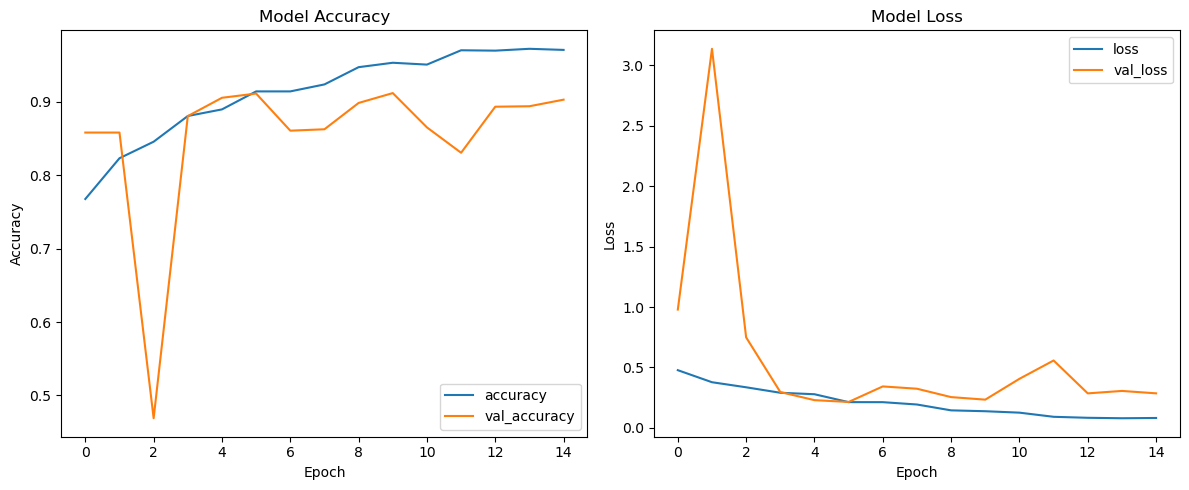

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

## Evaluation

In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8869 - loss: 0.3610
Test Loss 0.3584519326686859
Test Accuracy 0.8906649351119995


In [10]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1341
           1       0.59      0.79      0.67       223

    accuracy                           0.89      1564
   macro avg       0.77      0.85      0.80      1564
weighted avg       0.91      0.89      0.90      1564



# Adversarial Attacks

## Random Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: 1
Prediction: [[0.99953943]]
Prediction class: ['1']
Adversarial Prediction: [[5.672666e-10]]
Adversarial Predicted Class: ['0']


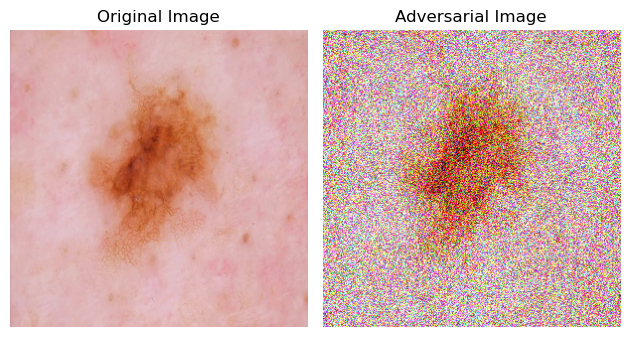

In [22]:
filepath = f"{root}data/ISIC_0026105.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.5
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [12]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [13]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.11317135549872123
RN TN Success rate: 0.0006393861892583121
RN FP Success rate: 0.19117647058823528


## FGSM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: 1
Prediction: [[0.99953943]]
Prediction class: ['1']
Adversarial Prediction: [[0.00033395]]
Adversarial Predicted Class: ['0']


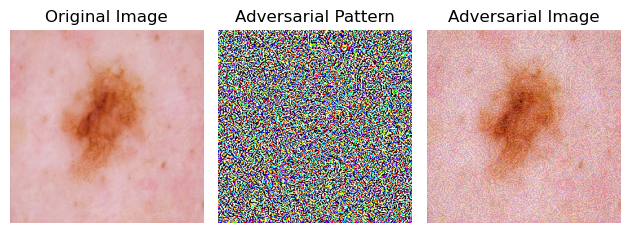

In [14]:
filepath = f"{root}data/ISIC_0026105.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.2
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [15]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [16]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.11381074168797954
FGSM TN Success rate: 0.0006393861892583121
FGSM FP Success rate: 0.19245524296675193


## Saliency Map Attack

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: 0
Prediction: [[0.02064716]]
Prediction class: ['0']
Adversarial Prediction: [[0.05734352]]
Adversarial Predicted Class: ['0']


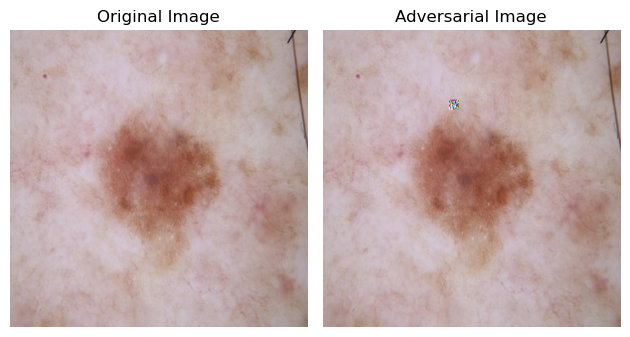

In [17]:
# filepath = f"{root}data/ISIC_0026105.jpg"
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 1
patch_size=30
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [18]:
res = []
eps = 1
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [19]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.055626598465473145
SM TN Success rate: 0.058184143222506396
SM FP Success rate: 0.0159846547314578


## Data export for analysis

In [20]:
test_df.to_csv(f"{root}/exp/test_df_HAM10000_ResNet.csv", index=False)